# Testing multiple objectives.

Imports

In [203]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import torch
import malt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Function definitions.

In [204]:
def define_model(num_features=32, hardcoded=False):
    
    # define model
    if hardcoded:
        regressor_cls = malt.models.regressor.HardcodedExactGaussianProcessRegressor
    else:
        regressor_cls = malt.models.regressor.ExactGaussianProcessRegressor

    model = malt.models.supervised_model.GaussianProcessSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=num_features, hidden_features=num_features
        ),
        regressor=regressor_cls(
            in_features=num_features, out_features=2
        ),
    )
    if torch.cuda.is_available():
        model.cuda()

    # define marginal log likelihood
    if hardcoded:
        mll = malt.models.marginal_likelihood.HardcodedExactMarginalLogLikelihood(
            model.likelihood, model
        )
    else:
        mll = malt.models.marginal_likelihood.ExactMarginalLogLikelihood(
            model.regressor.likelihood, model
        )        
    return model, mll

def get_data(ds):
    return getattr(malt.data.collections, ds)()

def train(model, data, mll, n_epochs=100,
          val_split=0.2, verbose=True):
    # get trainer
    trainer = malt.trainer.get_default_trainer(
        without_player=True,
        validation_split=val_split,
    )
    # train model
    model = trainer(
        model, data, mll,
        n_epochs=n_epochs, verbose=verbose,
    )
    return model

def evaluate(model, data, val_split=0.2):

    from malt.metrics.supervised_metrics import R2

    # split into training and validation
    ds_tr, ds_vl = data.split([1.0-val_split, val_split])
    metric = R2()
    train_res, test_res = metric(model, ds_tr), metric(model, ds_vl)
    return train_res, test_res

Perform tests.

In [218]:
from tqdm import tqdm

results = []
for hardcoded in [True, False]:
    
    data = get_data('esol')

    for idx in tqdm(range(40)):
        model, mll = define_model(hardcoded=hardcoded)
        data.shuffle(seed=idx)

        val_split = 0.125
        train(
            model, data, mll,
            val_split=val_split,
            n_epochs=150,
            verbose=False
        )
        
        model.eval()
        train_res, test_res = evaluate(
            model, data, val_split=val_split
        )
        results.append(
            {
                'index': idx,
                'hardcoded': hardcoded,
                'R2_train': train_res.item(),
                'R2_test': test_res.item()
            }
        )

Processing dgl graphs from scratch...
Processing molecule 1000/1128


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [09:01<00:00, 13.54s/it]


Processing dgl graphs from scratch...
Processing molecule 1000/1128


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [08:54<00:00, 13.35s/it]


<AxesSubplot:xlabel='hardcoded', ylabel='R2_train'>

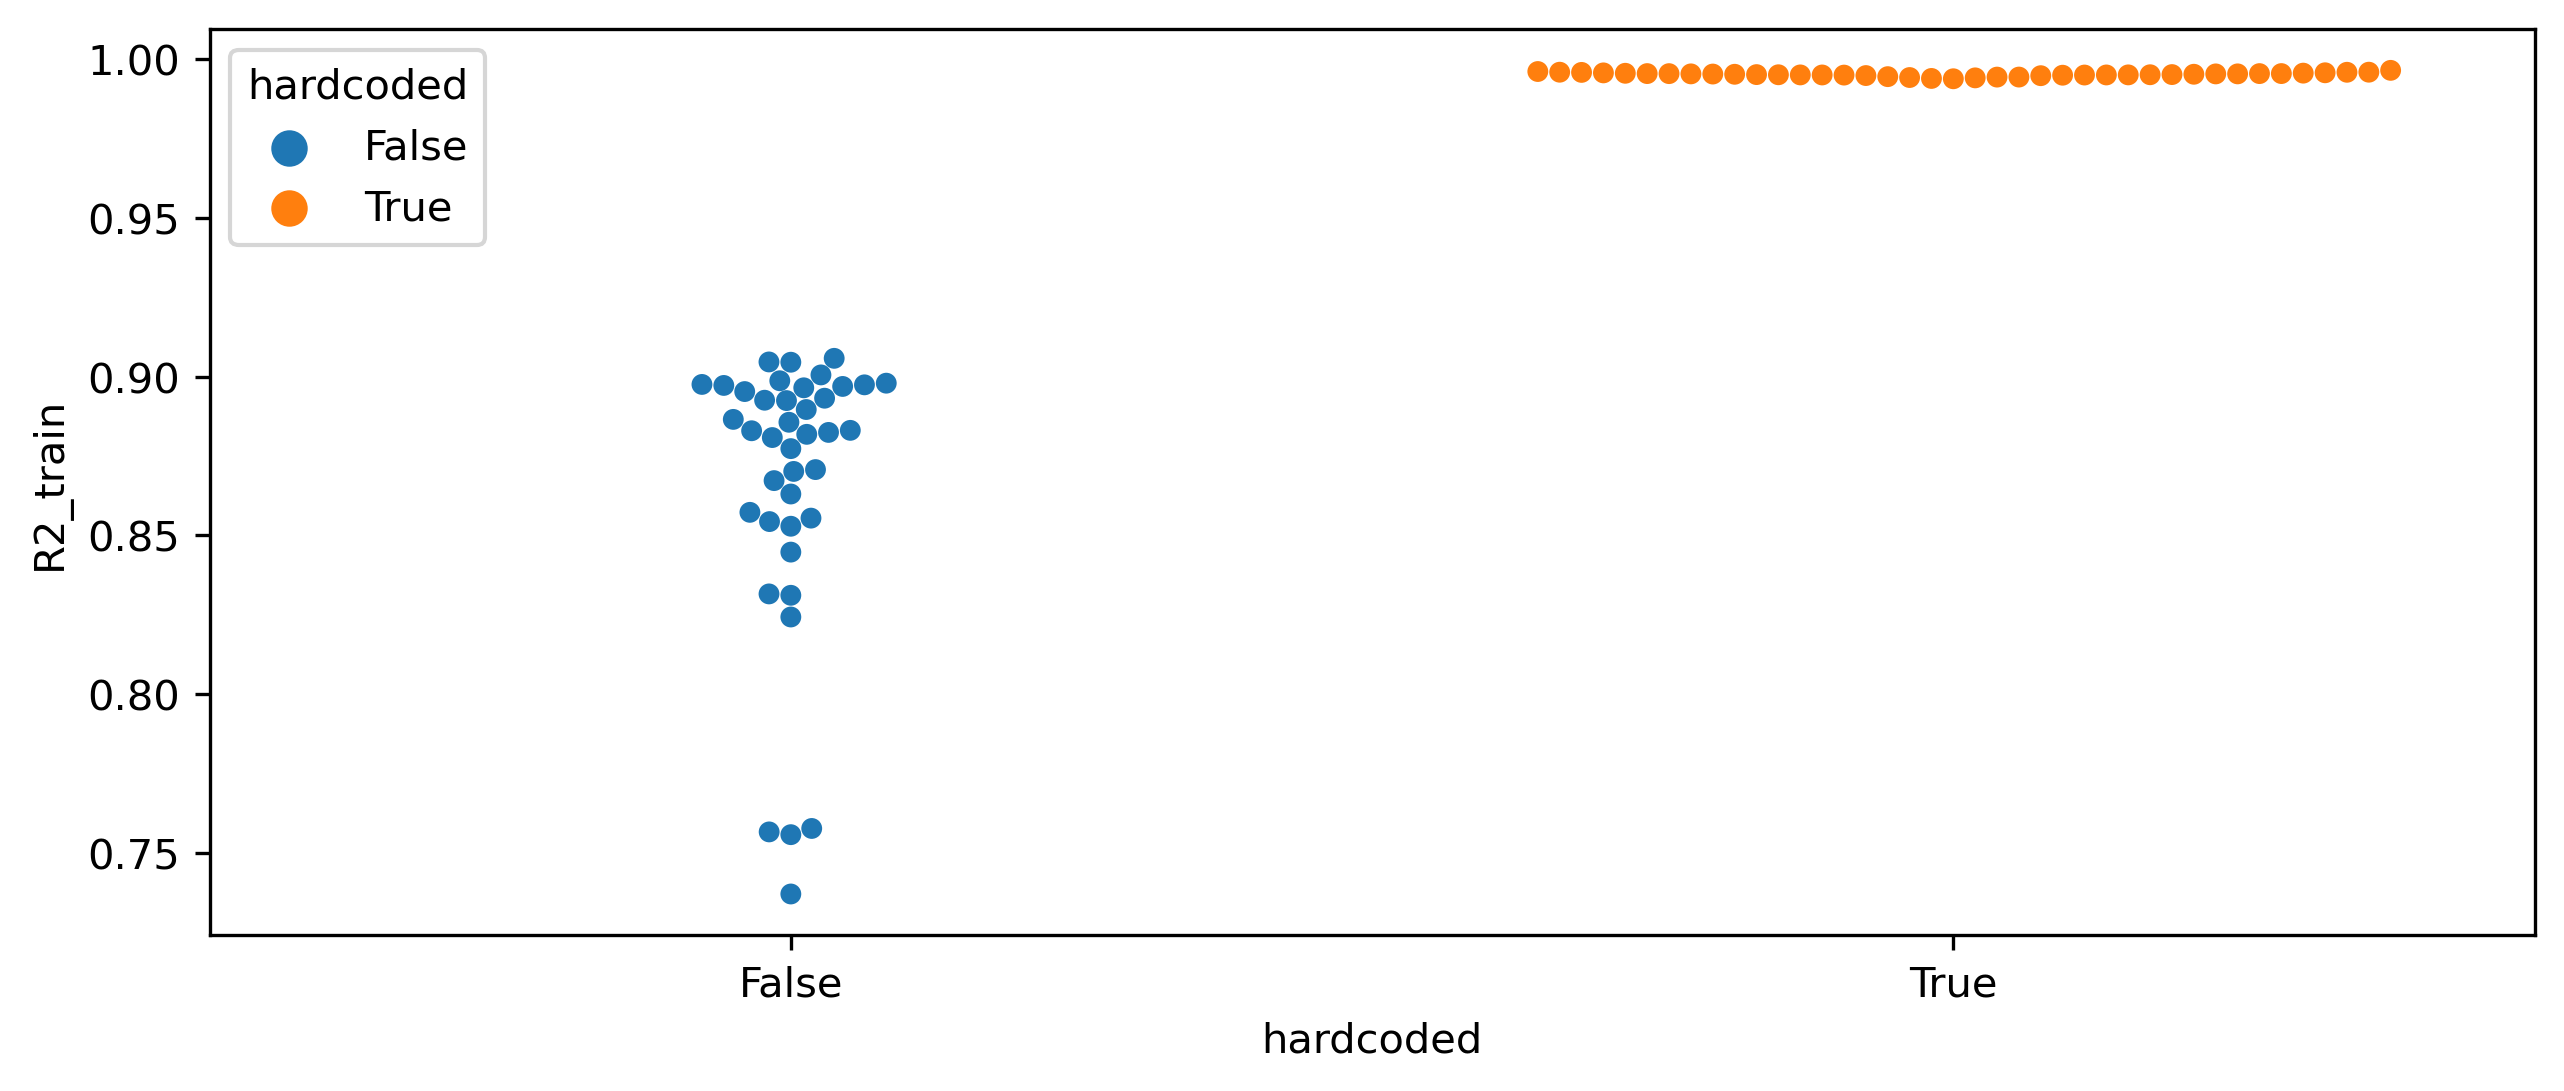

In [219]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

df = pd.DataFrame(results)
sns.swarmplot(data=df, x='hardcoded', y='R2_train', hue='hardcoded', ax=ax)

<AxesSubplot:xlabel='hardcoded', ylabel='R2_test'>

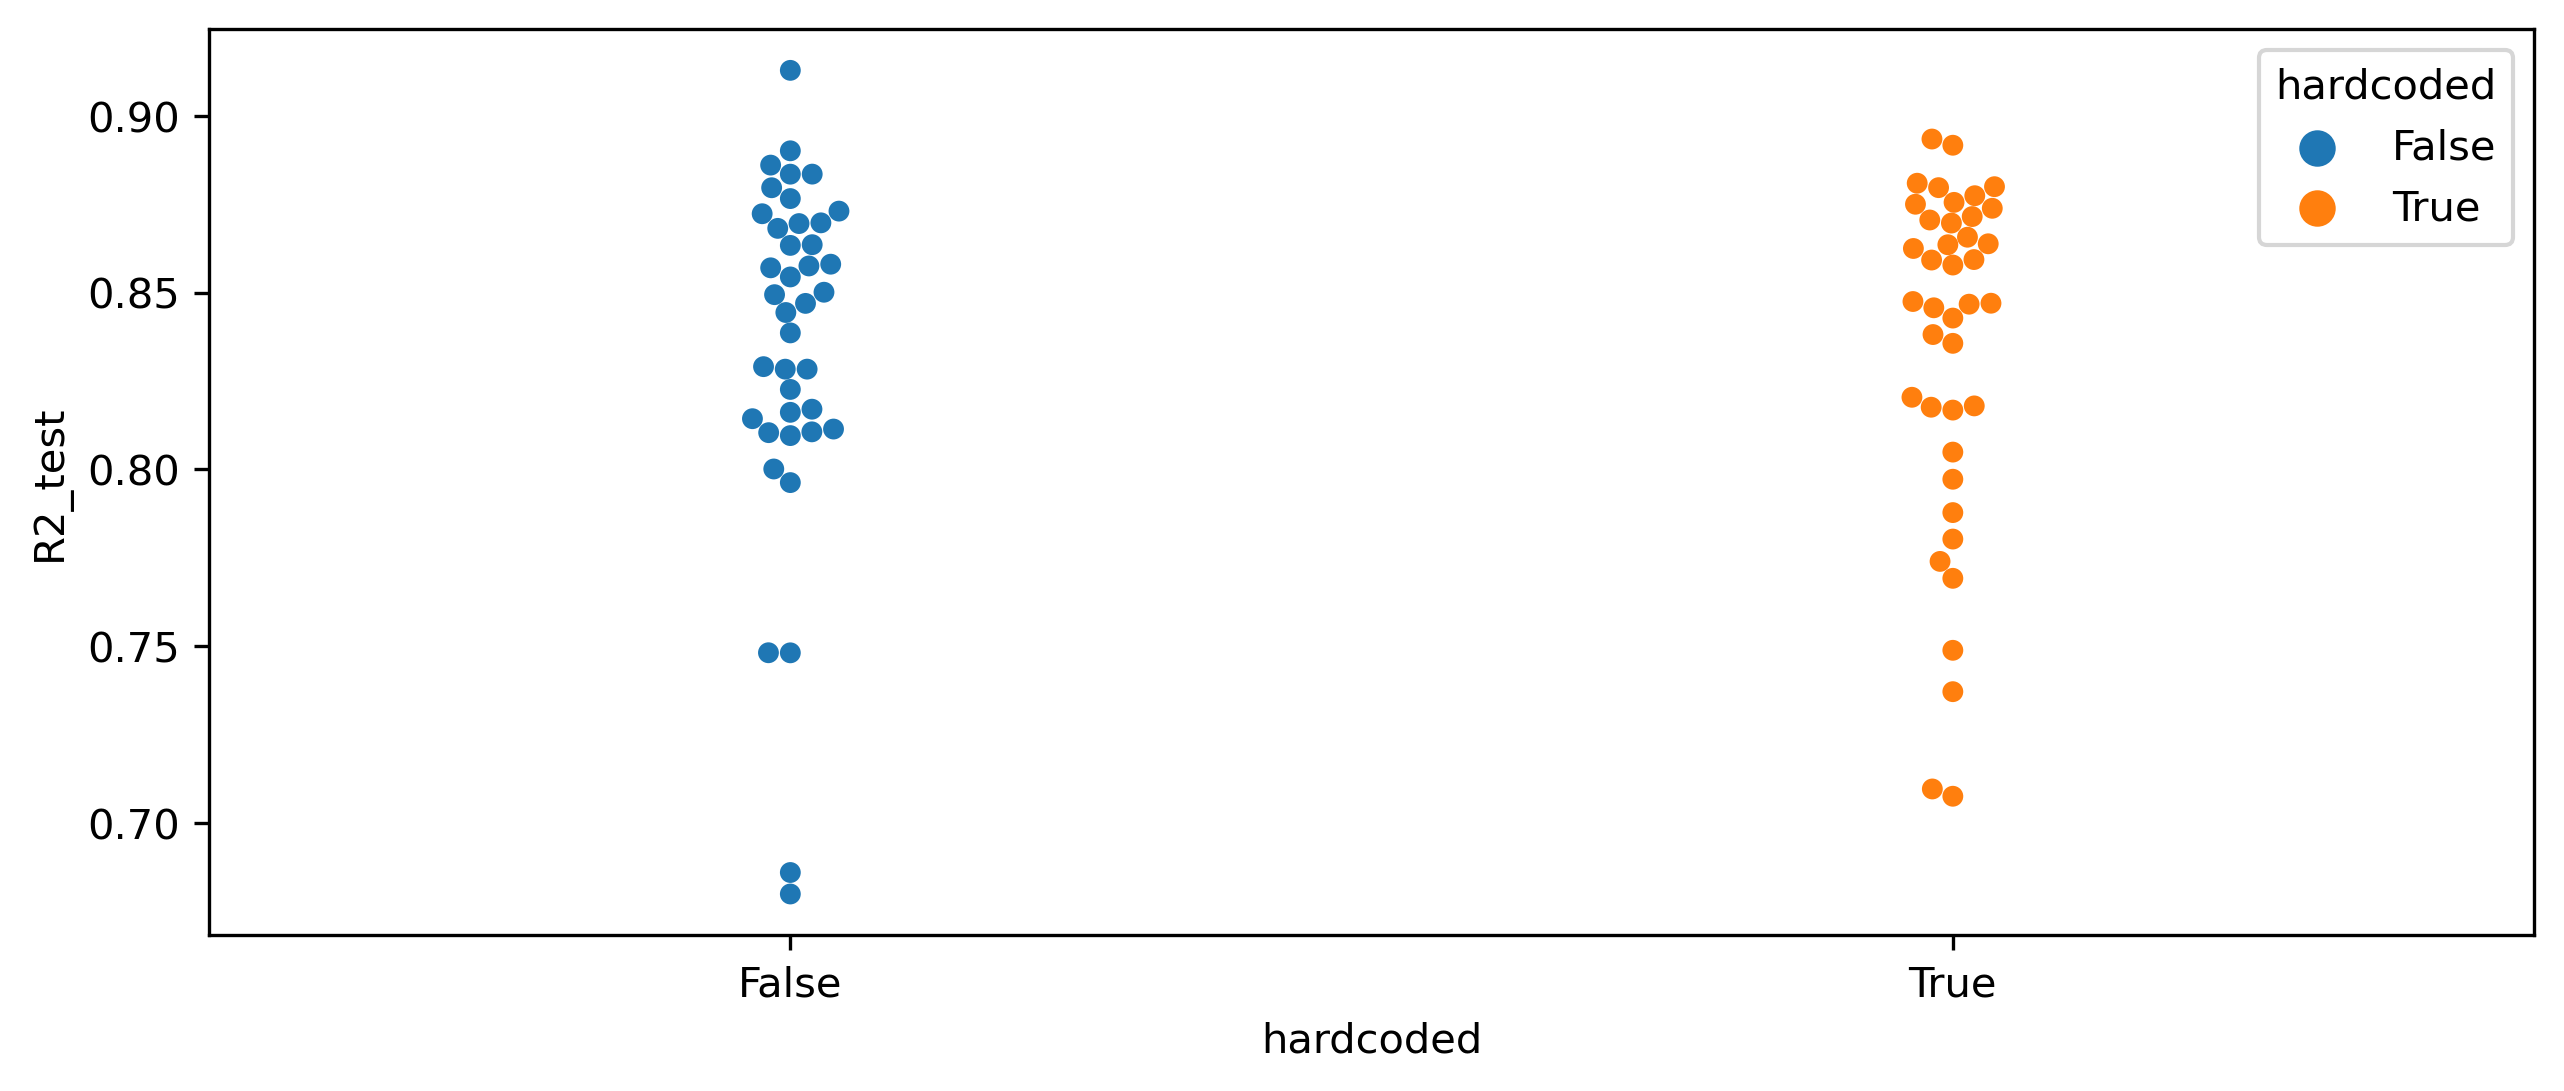

In [255]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

df = pd.DataFrame(results)
sns.swarmplot(data=df, x='hardcoded', y='R2_test', hue='hardcoded', ax=ax)

In [253]:
model.eval()
dist = model(g)
(y > dist.to_data_independent_dist().icdf(torch.Tensor([0.9]).cuda())).sum() / len(dist.loc)

tensor(0.6950, device='cuda:0')

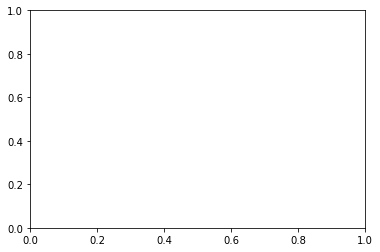

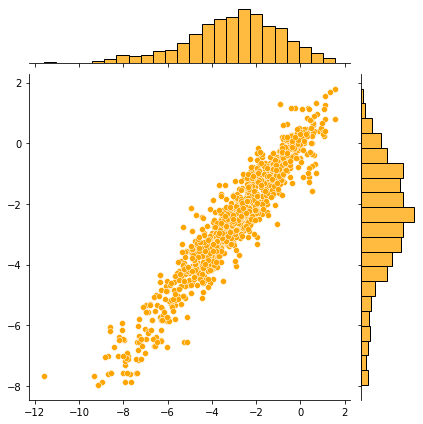

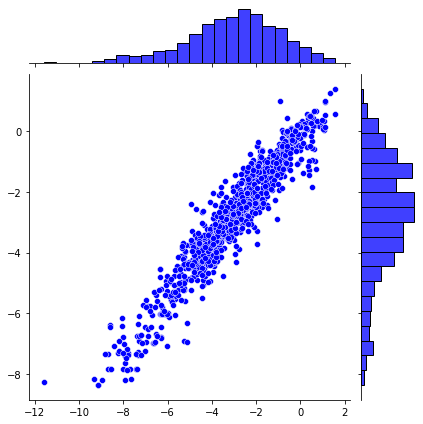

In [202]:
g, y = data.split([1.0 - val_split, val_split])[0].batch()

model.eval()
preds = model(g)

_, ax = plt.subplots()

plot = sns.jointplot(
    x = y.ravel().tolist(),
    # y = (preds.loc).tolist(),
    y = dist.to_data_independent_dist().icdf(torch.Tensor([0.99]).cuda()).tolist(),
    ax = ax,
    color='orange',
)

plot = sns.jointplot(
    x = y.ravel().tolist(),
    y = (preds.loc).tolist(),
    # y = dist.to_data_independent_dist().icdf(torch.Tensor([0.99]).cuda()).tolist()
    color='blue',
)

# plot.set_axis_labels('y', '\hat{y}')
# plt.title('gpytorch: training')